# Compilation of Findings: Plots, etc

## Difference in PII extraction for languages

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest, proportions_chisquare
from statsmodels.stats.multitest import multipletests

# Your data: (successes, total)
data = {
    "Spanish": (999, 9984),
    "English": (5569, 58791),
    "Dutch":   (1074, 12361),
    "French":  (686, 8569),
    "Italian": (670, 9630),
    "German":  (715, 10334),
    "Swedish": (760, 11824),
}

# Convert to DataFrame for clarity
df = pd.DataFrame(data, index=["successes", "total"]).T
df["failures"] = df["total"] - df["successes"]

print("=== Data Table ===")
print(df)

# -------------------------------
# 1. Chi-Squared Test of Independence
# -------------------------------
contingency_table = df[["successes", "failures"]].values
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\n=== Chi-Squared Test ===")
print(f"Chi2 statistic: {chi2:.4f}, p-value: {p:.4e}, dof: {dof}")

# -------------------------------
# 2. Pairwise Two-Proportion Z-tests
# -------------------------------
langs = list(data.keys())
results = []

for i in range(len(langs)):
    for j in range(i+1, len(langs)):
        lang1, lang2 = langs[i], langs[j]
        count = np.array([df.loc[lang1, "successes"], df.loc[lang2, "successes"]])
        nobs = np.array([df.loc[lang1, "total"], df.loc[lang2, "total"]])
        stat, pval = proportions_ztest(count, nobs)
        results.append((lang1, lang2, stat, pval))

# Multiple comparison correction
results_df = pd.DataFrame(results, columns=["Lang1", "Lang2", "Z-stat", "p-raw"])
results_df["p-adj"] = multipletests(results_df["p-raw"], method="holm")[1]

print("\n=== Pairwise Comparisons (Holm-adjusted) ===")
print(results_df.sort_values("p-adj"))


=== Data Table ===
         successes  total  failures
Spanish        999   9984      8985
English       5569  58791     53222
Dutch         1074  12361     11287
French         686   8569      7883
Italian        670   9630      8960
German         715  10334      9619
Swedish        760  11824     11064

=== Chi-Squared Test ===
Chi2 statistic: 226.6788, p-value: 3.9149e-46, dof: 6

=== Pairwise Comparisons (Holm-adjusted) ===
      Lang1    Lang2     Z-stat         p-raw         p-adj
10  English  Swedish  10.576407  3.833778e-26  8.050933e-25
5   Spanish  Swedish   9.668355  4.109290e-22  8.218579e-21
9   English   German   8.327709  8.242182e-17  1.566015e-15
8   English  Italian   7.947509  1.902987e-15  3.425377e-14
4   Spanish   German   7.915335  2.465890e-15  4.192013e-14
3   Spanish  Italian   7.649744  2.013796e-14  3.222073e-13
14    Dutch  Swedish   6.639523  3.146996e-11  4.720494e-10
13    Dutch   German   4.927054  8.347863e-07  1.168701e-05
2   Spanish   French   4.72

In [1]:
import pandas as pd
from scipy.stats import f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Your data (percentages converted to proportions)
data = {
    "Language": ["Spanish", "English", "Dutch", "French", "German", "Italian", "Swedish"],
    "Exp1": [0.1001, 0.0947, 0.0869, 0.0801, 0.0692, 0.0696, 0.0643],
    "Exp2": [0.1150, 0.1138, 0.1032, 0.0963, 0.0851, 0.0778, 0.0755],
    "Exp3": [0.1077, 0.1121, 0.0889, 0.0819, 0.0742, 0.0763, 0.0677],
}

df = pd.DataFrame(data)
df_melted = df.melt(id_vars="Language", value_vars=["Exp1", "Exp2", "Exp3"],
                    var_name="Run", value_name="ExtractionRate")

# 1️⃣ One-way ANOVA
groups = [df_melted.loc[df_melted["Language"] == lang, "ExtractionRate"]
          for lang in df["Language"]]
anova_stat, anova_p = f_oneway(*groups)
print(f"ANOVA F-statistic = {anova_stat:.3f}, p-value = {anova_p:.4e}")

# 2️⃣ Post-hoc (Tukey HSD)
tukey = pairwise_tukeyhsd(df_melted["ExtractionRate"],
                          df_melted["Language"],
                          alpha=0.05)
print(tukey)


ANOVA F-statistic = 11.394, p-value = 1.0701e-04
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
  Dutch English   0.0139 0.3854 -0.0083  0.0361  False
  Dutch  French  -0.0069 0.9294 -0.0291  0.0153  False
  Dutch  German  -0.0168 0.2006  -0.039  0.0054  False
  Dutch Italian  -0.0184 0.1352 -0.0406  0.0038  False
  Dutch Spanish   0.0146 0.3317 -0.0076  0.0368  False
  Dutch Swedish  -0.0238 0.0317  -0.046 -0.0016   True
English  French  -0.0208 0.0735  -0.043  0.0014  False
English  German  -0.0307 0.0047 -0.0529 -0.0085   True
English Italian  -0.0323  0.003 -0.0545 -0.0101   True
English Spanish   0.0007    1.0 -0.0215  0.0229  False
English Swedish  -0.0377 0.0007 -0.0599 -0.0155   True
 French  German  -0.0099 0.7249 -0.0321  0.0123  False
 French Italian  -0.0115 0.5829 -0.0337  0.0107  False
 French Spanish   0.0215 0.0603 -0.0007  0.0437  False
 French Swedish 

In [4]:
from statsmodels.stats.anova import AnovaRM

anova_rm = AnovaRM(df_melted, depvar='ExtractionRate', subject='Run', within=['Language'])
res = anova_rm.fit()
print(res)

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
Language 61.1309 6.0000 12.0000 0.0000



In [2]:
# Nonparametric alternative
h, p_kw = kruskal(*groups)
print(f"Kruskal–Wallis H = {h:.3f}, p = {p_kw:.4e}")


Kruskal–Wallis H = 16.745, p = 1.0269e-02


## Multiple seeds

In [10]:
import pandas as pd
import re

# Data from the table organized in a dictionary
data = {
    'SFT': [
        [0.7147, '1 (1)', '1604 (1334)', '91 (15)', '11754 (4453)'],
        [0.7254, '2 (2)', '376 (343)', '36 (15)', '10078 (3384)'],
        [0.7188, '0 (0)', '643 (534)', '29 (13)', '6995 (2088)'],
        [0.7177, '0 (0)', '2925 (2014)', '36 (12)', '7043 (3361)'],
        [0.7200, '1 (1)', '2262 (1181)', '36 (15)', '13307 (4915)'],
    ],
    'DP': [
        [0.6993, '0 (0)', '161 (154)', '30 (11)', '5624 (1589)'],
        [0.7004, '0 (0)', '450 (375)', '31 (14)', '10091 (3796)'],
        [0.7033, '0 (0)', '370 (290)', '21 (14)', '5325 (1569)'],
    ],
    'UnDial': [
        [0.6725, '1 (1)', '1587 (1103)', '31 (13)', '9456 (3593)'],
        [0.7101, '3 (3)', '1136 (970)', '31 (13)', '12679 (4370)'],
        [0.7040, '3 (3)', '876 (774)', '26 (12)', '6611 (2072)'],
        [0.7031, '0 (0)', '2462 (1589)', '23 (12)', '10688 (3973)'],
        [0.7110, '0 (0)', '2094 (1369)', '34 (19)', '10895 (5351)'],
    ],
    'DPO': [
        [0.7084, '1 (1)', '1163 (1009)', '31 (13)', '6298 (2860)'],
        [0.7285, '1 (1)', '346 (327)', '38 (15)', '8817 (2270)'],
        [0.7241, '1 (1)', '282 (216)', '23 (11)', '4070 (1078)'],
        [0.7211, '3 (3)', '2877 (2289)', '28 (11)', '4981 (2360)'],
        [0.7245, '2 (2)', '2045 (1196)', '35 (15)', '10485 (3992)'],
    ]
}

def parse_value(value_str):
    """Parses strings like '1 (1)' into two separate numbers."""
    match = re.match(r'(\d+)\s*\((\d+)\)', value_str)
    if match:
        return int(match.group(1)), int(match.group(2))
    raise ValueError(f"Invalid format: {value_str}")

results = {}

# Process each method (SFT, DP, etc.)
for method, runs in data.items():
    # Create a DataFrame for the current method
    df = pd.DataFrame(runs, columns=['Task Performance', 'Regular Single', 'Regular Cross', 'Enhanced Single', 'Enhanced Cross'])

    # Parse the columns that have the 'value (distinct_value)' format
    for col in ['Regular Single', 'Regular Cross', 'Enhanced Single', 'Enhanced Cross']:
        df[[f'{col} Total', f'{col} Distinct']] = df[col].apply(lambda x: pd.Series(parse_value(x)))
        df = df.drop(columns=[col])

    # Calculate the mean and standard deviation for all columns
    stats = df.agg(['mean', 'std'])
    results[method] = stats

# --- Output Section ---

# 1. Print the calculated statistics to the console
print("Calculated Statistics:\n")
for method, stats in results.items():
    print(f"--- {method} ---")
    print(stats)
    print("\n")

Calculated Statistics:

--- SFT ---
      Task Performance  Regular Single Total  Regular Single Distinct  \
mean          0.719320               0.80000                  0.80000   
std           0.003926               0.83666                  0.83666   

      Regular Cross Total  Regular Cross Distinct  Enhanced Single Total  \
mean          1562.000000              1081.20000              45.600000   
std           1072.460955               668.64617              25.559734   

      Enhanced Single Distinct  Enhanced Cross Total  Enhanced Cross Distinct  
mean                 14.000000           9835.400000              3640.200000  
std                   1.414214           2813.239112              1099.849399  


--- DP ---
      Task Performance  Regular Single Total  Regular Single Distinct  \
mean          0.701000                   0.0                      0.0   
std           0.002066                   0.0                      0.0   

      Regular Cross Total  Regular Cross D

In [11]:
# 2. Generate and print the LaTeX table
latex_table = r"""
\begin{table*}[ht]
\centering
\footnotesize
\setlength{\tabcolsep}{4pt}
\begin{tabular}{
  >{\centering\arraybackslash}m{1.2cm}
  >{\centering\arraybackslash}m{2.2cm}
  *{4}{>{\centering\arraybackslash}m{2.2cm}}
}
\toprule
& \multirow{2}{*}{\textbf{\makecell[c]{Task\\Performance$\uparrow$}}}
& \multicolumn{2}{c}{\textbf{Regular TPA}}
& \multicolumn{2}{c}{\textbf{Enhanced TPA}} \\
\cmidrule(lr){3-4} \cmidrule(lr){5-6}
& & \textbf{Single$\downarrow$} & \textbf{Cross$\downarrow$} & \textbf{Single$\downarrow$} & \textbf{Cross$\downarrow$} \\
\midrule
"""

for method, stats in results.items():
    latex_table += f"\\textbf{{{method}}} & "
    latex_table += f"{stats.loc['mean', 'Task Performance']:.4f} $\\pm$ {stats.loc['std', 'Task Performance']:.4f} & "

    for col_type in ['Regular', 'Enhanced']:
        for col_granularity in ['Single', 'Cross']:
            col_name = f'{col_type} {col_granularity}'
            mean_total = stats.loc['mean', f'{col_name} Total']
            std_total = stats.loc['std', f'{col_name} Total']
            mean_distinct = stats.loc['mean', f'{col_name} Distinct']
            std_distinct = stats.loc['std', f'{col_name} Distinct']

            # Format the string with mean and std, rounded to one decimal place
            latex_table += f"{mean_total:.1f} $\\pm$ {std_total:.1f} ({mean_distinct:.1f} $\\pm$ {std_distinct:.1f}) & "
    
    # Clean up trailing ampersand and add new line for the next row
    latex_table = latex_table.strip('& ') + r" \\ \midrule" + "\n"


latex_table += r"""
\bottomrule
\end{tabular}
\caption{Mean and standard deviation of PII memorization and task performance across different training methods for Llama 3.2 1B. Each cell shows \textit{Total PII (Distinct PII)} for Single-sampling (temperature 0) and Cross-memorization settings.}
\label{tab:llama_summary}
\end{table*}
"""

print("\nGenerated LaTeX Table:\n")
print(latex_table)


Generated LaTeX Table:


\begin{table*}[ht]
\centering
\footnotesize
\setlength{\tabcolsep}{4pt}
\begin{tabular}{
  >{\centering\arraybackslash}m{1.2cm}
  >{\centering\arraybackslash}m{2.2cm}
  *{4}{>{\centering\arraybackslash}m{2.2cm}}
}
\toprule
& \multirow{2}{*}{\textbf{\makecell[c]{Task\\Performance$\uparrow$}}}
& \multicolumn{2}{c}{\textbf{Regular TPA}}
& \multicolumn{2}{c}{\textbf{Enhanced TPA}} \\
\cmidrule(lr){3-4} \cmidrule(lr){5-6}
& & \textbf{Single$\downarrow$} & \textbf{Cross$\downarrow$} & \textbf{Single$\downarrow$} & \textbf{Cross$\downarrow$} \\
\midrule
\textbf{SFT} & 0.7193 $\pm$ 0.0039 & 0.8 $\pm$ 0.8 (0.8 $\pm$ 0.8) & 1562.0 $\pm$ 1072.5 (1081.2 $\pm$ 668.6) & 45.6 $\pm$ 25.6 (14.0 $\pm$ 1.4) & 9835.4 $\pm$ 2813.2 (3640.2 $\pm$ 1099.8) \\ \midrule
\textbf{DP} & 0.7010 $\pm$ 0.0021 & 0.0 $\pm$ 0.0 (0.0 $\pm$ 0.0) & 327.0 $\pm$ 149.2 (273.0 $\pm$ 111.5) & 27.3 $\pm$ 5.5 (13.0 $\pm$ 1.7) & 7013.3 $\pm$ 2669.5 (2318.0 $\pm$ 1280.0) \\ \midrule
\textbf{UnDial} & 0.7001

## Model scaling and architectures

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Data from the table provided by the user
data = {
    'Model': [
        'LLaMa3.2-1B-Base', 'LLaMa3.2-1B-FT',
        'LLaMa3.2-3B-Base', 'LLaMa3.2-3B-FT',
        'LLaMa3.1-8B-Base', 'LLaMa3.1-8B-FT',
        'Gemma3-1B-Base', 'Gemma3-1B-FT',
        'Gemma3-4B-Base', 'Gemma3-4B-FT',
        'Gemma3-12B-Base', 'Gemma3-12B-FT',
        'Qwen3-1.7B-Base', 'Qwen3-1.7B-FT'
    ],
    'Task Performance': [
        0.5227, 0.7147, 0.5484, 0.7304, 0.3990, 0.7386,
        0.5541, 0.7049, 0.5239, 0.7273, 0.5199, 0.7191,
        0.5403, 0.7267
    ],
    'Enhanced TPA - Greedy (Total PII)': [
        25, 91, 40, 57, 83, 48,
        16, 21, 38, 24, 90, 70,
        15, 47
    ],
    'Enhanced TPA - Greedy (Distinct PII)': [
        15, 15, 22, 25, 41, 29,
        9, 12, 24, 15, 44, 36,
        12, 19
    ],
    'Regular TPA - Cross-memorization (Distinct PII)': [
        719, 1334, 558, 1236, 1002,
        310, 1090, 1174, 883, 301,
        671, 770, 1528, 4626
    ],
    'Architecture': [
        'LLaMa', 'LLaMa', 'LLaMa', 'LLaMa', 'LLaMa', 'LLaMa',
        'Gemma', 'Gemma', 'Gemma', 'Gemma', 'Gemma', 'Gemma',
        'Qwen', 'Qwen'
    ],
    'Type': [
        'Base', 'FT', 'Base', 'FT', 'Base', 'FT',
        'Base', 'FT', 'Base', 'FT', 'Base', 'FT',
        'Base', 'FT'
    ],
    'Size': [1, 1, 3, 3, 8, 8, 1, 1, 4, 4, 12, 12, 1.7, 1.7],
}
df = pd.DataFrame(data)

# Define colors for each architecture
colors = {
    'LLaMa': 'blue',
    'Gemma': 'green',
    'Qwen': 'red'
}

# Define markers for model sizes
def get_marker(size):
    if size <= 1.7:
        return 'o'
    elif size <= 4:
        return 's'
    else:
        return '^'

df['Marker'] = df['Size'].apply(get_marker)
plt.style.use('seaborn-v0_8-whitegrid')


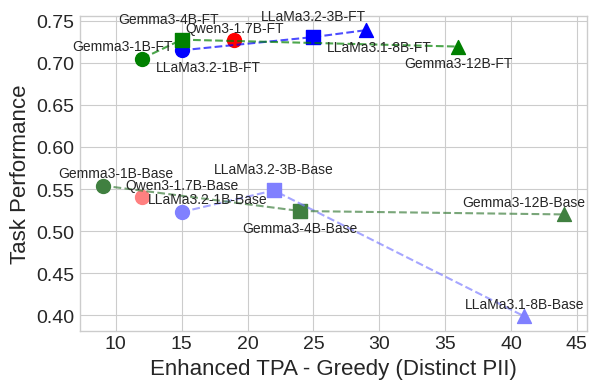

In [6]:
memorization_column = 'Enhanced TPA - Greedy (Distinct PII)'

df['note_offsetx'] = [2, 2, 0, 0, 0, 1, 1, -1.5, 0, -1, -3, 0, 3, 0]
df['note_offsety'] = [1.5, -2, 2.5, 2.5, 1.5, -2, 1.5, 1.5, -2, 2.5, 1.5, -2, 1.5, 1.5]

fig, ax = plt.subplots(figsize=(6, 4))

# Plot lines connecting models of the same architecture and type
for arch in df['Architecture'].unique():
    for model_type in ['Base', 'FT']:
        subset = df[(df['Architecture'] == arch) & (df['Type'] == model_type)].sort_values('Size')
        
        color = colors[arch]
        if model_type == 'Base':
            # Use a lighter shade for base models
            rgb = mcolors.to_rgb(color)
            hsv = mcolors.rgb_to_hsv(rgb)
            hsv[1] *= 0.5  # Reduce saturation for a lighter effect
            color = mcolors.hsv_to_rgb(hsv)
        
        # Swapped axes for transposition
        ax.plot(subset[memorization_column], subset['Task Performance'],
                marker='', linestyle='--', color=color, alpha=0.7)

# Plot markers and labels
for i, row in df.iterrows():
    color = colors[row['Architecture']]
    if row['Type'] == 'Base':
        rgb = mcolors.to_rgb(color)
        hsv = mcolors.rgb_to_hsv(rgb)
        hsv[1] *= 0.5
        color = mcolors.hsv_to_rgb(hsv)
        
    # Swapped axes for transposition
    ax.scatter(row[memorization_column], row['Task Performance'],
               c=[color], marker=row['Marker'], s=100, label=f"{row['Architecture']} {row['Type']}")

    # if row['Type'] == 'FT':
    ax.text(row[memorization_column] + 1 * row['note_offsetx'], row['Task Performance'] + 0.01 * row['note_offsety'],
                row['Model'], fontsize=10, ha='center', va='center')

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='LLaMa'),
    Line2D([0], [0], color='green', lw=2, label='Gemma'),
    Line2D([0], [0], color='red', lw=2, label='Qwen'),
    Line2D([0], [0], marker='o', color='grey', label='1B/1.7B Models', linestyle='None', markersize=10),
    Line2D([0], [0], marker='s', color='grey', label='3B/4B Models', linestyle='None', markersize=10),
    Line2D([0], [0], marker='^', color='grey', label='8B/12B Models', linestyle='None', markersize=10),
    Line2D([0], [0], color='gray', lw=1, ls='--', label='Base (Lighter)'),
    Line2D([0], [0], color='black', lw=1, ls='-', label='FT (Darker)')

]
# ax.legend(handles=legend_elements, fontsize=9)

ax.set_xlabel(memorization_column, fontsize=16)
ax.set_ylabel('Task Performance', fontsize=16)
ax.grid(True)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.savefig(f'model_performance_vs_{memorization_column}.pdf', bbox_inches='tight')

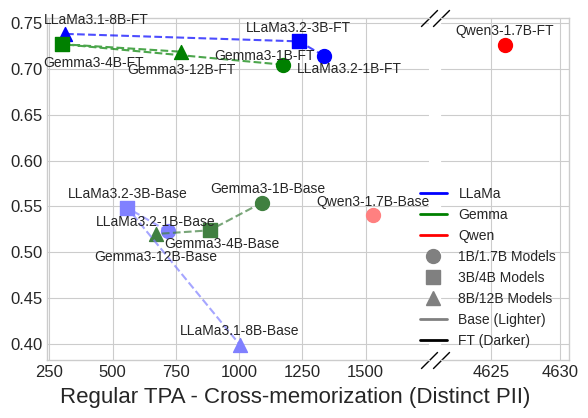

In [4]:
memorization_column = 'Regular TPA - Cross-memorization (Distinct PII)'

# 'Model': [
#         'LLaMa3.2-1B-Base', 'LLaMa3.2-1B-FT',
#         'LLaMa3.2-3B-Base', 'LLaMa3.2-3B-FT',
#         'LLaMa3.1-8B-Base', 'LLaMa3.1-8B-FT',
#         'Gemma3-1B-Base', 'Gemma3-1B-FT',
#         'Gemma3-4B-Base', 'Gemma3-4B-FT',
#         'Gemma3-12B-Base', 'Gemma3-12B-FT',
#         'Qwen3-1.7B-Base', 'Qwen3-1.7B-FT'
#     ],

df['note_offsetx'] = [-2, 4, 0, 0, 0, 5, 1, -3, 2, 5, 0, 0, 0, 0]
df['note_offsety'] = [1, -1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1, -1.5, -2, -2.5, -2, 1.5, 1.5]

# Create two subplots with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6, 4),
                               gridspec_kw={'width_ratios': [3, 1]})

# Define the x-axis limits before and after the break
xlims = [(df[memorization_column].min()*0.8, 1749), (df[memorization_column].max()*0.999, df[memorization_column].max()*1.001)]

# Loop through both axes and plot identical data
for ax, xlim in zip((ax1, ax2), xlims):
    for arch in df['Architecture'].unique():
        for model_type in ['Base', 'FT']:
            subset = df[(df['Architecture'] == arch) & (df['Type'] == model_type)].sort_values('Size')
            
            color = colors[arch]
            if model_type == 'Base':
                rgb = mcolors.to_rgb(color)
                hsv = mcolors.rgb_to_hsv(rgb)
                hsv[1] *= 0.5  # lighter
                color = mcolors.hsv_to_rgb(hsv)
            
            ax.plot(subset[memorization_column], subset['Task Performance'],
                    marker='', linestyle='--', color=color, alpha=0.7)

    for i, row in df.iterrows():
        color = colors[row['Architecture']]
        if row['Type'] == 'Base':
            rgb = mcolors.to_rgb(color)
            hsv = mcolors.rgb_to_hsv(rgb)
            hsv[1] *= 0.5
            color = mcolors.hsv_to_rgb(hsv)
            
        ax.scatter(row[memorization_column], row['Task Performance'],
                   c=[color], marker=row['Marker'], s=100,
                   label=f"{row['Architecture']} {row['Type']}")
        
        if xlim[0] <= row[memorization_column] <= xlim[1]:
            ax.text(row[memorization_column] + 25 * row['note_offsetx'],
                    row['Task Performance'] + 0.01 * row['note_offsety'],
                    row['Model'], fontsize=10, ha='center', va='center')

    ax.set_xlim(xlim)
    ax.grid(True)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

# Hide spines and add diagonal break marks
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()

d = 1  # diagonal line size
# kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
kwargs = dict(transform=ax1.transAxes, marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
# ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
# ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
ax1.plot([1, 1], [0, 1], **kwargs)


kwargs.update(transform=ax2.transAxes)
# ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
# ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot([0, 0], [0, 1], **kwargs)

# Add legend on first axis only
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='LLaMa'),
    Line2D([0], [0], color='green', lw=2, label='Gemma'),
    Line2D([0], [0], color='red', lw=2, label='Qwen'),
    Line2D([0], [0], marker='o', color='grey', label='1B/1.7B Models', linestyle='None', markersize=10),
    Line2D([0], [0], marker='s', color='grey', label='3B/4B Models', linestyle='None', markersize=10),
    Line2D([0], [0], marker='^', color='grey', label='8B/12B Models', linestyle='None', markersize=10),
    Line2D([0], [0], color='gray', lw=2, ls='-', label='Base (Lighter)'),
    Line2D([0], [0], color='black', lw=2, ls='-', label='FT (Darker)')
]
ax2.legend(handles=legend_elements, fontsize=10, loc='lower right')

# Labels
fig.text(0.5, -0.02, memorization_column, ha='center', fontsize=16)
# ax1.set_ylabel('Task Performance', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig(f'model_performance_vs_{memorization_column}.pdf', bbox_inches='tight')
plt.show()
